In [1]:
import pandas as pd
from datetime import datetime, timedelta
import os
import asyncio
from binance.client import AsyncClient, HistoricalKlinesType


In [11]:
client = await AsyncClient.create()

<h1>DOWNLOADER F()</h1>

In [3]:
async def get_batch_historical_candles(symbols, days, interval = "1m", klines_type=HistoricalKlinesType.SPOT, limit_per_second = 2):
  new_dir = "Binance_Historical_%s_%s_%i_days_%s" % (interval, klines_type.name, days, str(datetime.utcnow().replace(microsecond=0).isoformat()))
  os.mkdir(new_dir)
  now = datetime.utcnow()
  start = str(now - timedelta(days = days))
  
  chunks = []
  for idx, _ in enumerate(symbols):
    if idx % limit_per_second == 0:
      symbols_chunk = symbols[idx:idx+limit_per_second]
      futures_chunk = []
      
      for symbol in symbols_chunk:
        futures_chunk.append(client.get_historical_klines(symbol = symbol, interval = interval,
                                      start_str = start, end_str = None, limit = 1000, klines_type=klines_type))
        
      chunks.append(futures_chunk)
      
  for index, chunk in enumerate(chunks):
    print("Fetching data for ↓ %s %s" % (klines_type.name, interval), "%i / %i" % (index, len(chunks)))
    results = await asyncio.gather(*chunk)
    
    for i, bars in enumerate(results):
      print(symbols[index*limit_per_second+i])
      try:
        df = bars_to_df(bars)
        df.to_csv("%s/%s_%s_%s.csv" % (new_dir, symbols[index*limit_per_second+i], klines_type.name, interval))
      except:
        print("raw: ", bars)
        print("Couldn't construct DataFrame from raw data for %s" % symbols[index*limit_per_second+i])
    
def bars_to_df(bars):
  df = pd.DataFrame(bars)
  df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
  df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                "Close Time", "Quote Asset Volume", "Number of Trades",
                "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
  df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
  df.set_index("Date", inplace = True)
  for column in df.columns:
      df[column] = pd.to_numeric(df[column], errors = "coerce")
      
  return df
      

In [4]:
futures_info = await client.futures_exchange_info()
spot_info = await client.get_exchange_info()

In [5]:
symbols_futures = list(map(lambda x: x['symbol'], futures_info['symbols']))
symbols_spot = list(map(lambda x: x['symbol'], spot_info['symbols']))


In [6]:
await get_batch_historical_candles(symbols=symbols_futures, days=2, interval="1m", limit_per_second=6, klines_type=HistoricalKlinesType.FUTURES)
await get_batch_historical_candles(symbols=symbols_spot, days=2, interval="1m", limit_per_second=6, klines_type=HistoricalKlinesType.SPOT)


Fetching data for ↓ FUTURES 1m 0 / 28
BTCUSDT
ETHUSDT
BCHUSDT
XRPUSDT
EOSUSDT
LTCUSDT
Fetching data for ↓ FUTURES 1m 1 / 28
TRXUSDT
ETCUSDT
LINKUSDT
XLMUSDT
ADAUSDT
XMRUSDT
Fetching data for ↓ FUTURES 1m 2 / 28
DASHUSDT
ZECUSDT
XTZUSDT
BNBUSDT
ATOMUSDT
ONTUSDT
Fetching data for ↓ FUTURES 1m 3 / 28
IOTAUSDT
BATUSDT
VETUSDT
NEOUSDT
QTUMUSDT
IOSTUSDT
Fetching data for ↓ FUTURES 1m 4 / 28
THETAUSDT
ALGOUSDT
ZILUSDT
KNCUSDT
ZRXUSDT
COMPUSDT
Fetching data for ↓ FUTURES 1m 5 / 28
OMGUSDT
DOGEUSDT
SXPUSDT
KAVAUSDT
BANDUSDT
RLCUSDT
Fetching data for ↓ FUTURES 1m 6 / 28
WAVESUSDT
MKRUSDT
SNXUSDT
DOTUSDT
DEFIUSDT
YFIUSDT
Fetching data for ↓ FUTURES 1m 7 / 28
BALUSDT
CRVUSDT
TRBUSDT
RUNEUSDT
SUSHIUSDT
SRMUSDT
Fetching data for ↓ FUTURES 1m 8 / 28
EGLDUSDT
SOLUSDT
ICXUSDT
STORJUSDT
BLZUSDT
UNIUSDT
Fetching data for ↓ FUTURES 1m 9 / 28
AVAXUSDT
FTMUSDT
HNTUSDT
ENJUSDT
FLMUSDT
TOMOUSDT
Fetching data for ↓ FUTURES 1m 10 / 28
RENUSDT
KSMUSDT
NEARUSDT
AAVEUSDT
FILUSDT
RSRUSDT
Fetching data for ↓ FUTURES

- downloaded data is placed in new directory in the root, so it can be easily cleaned
- target data sets that we want to preserve should be manually moved to `./raw_data` dir

<h1>Raw Data Processing </h1>

<h3>Merging time series</h3>
<table>
<tr>
<th>[BTCUSDT]</th>
<th>[ETHUSDT]</th>
</tr>
<tr>
<td>[Close]</td>
<td>[Close]</td>
</tr>
<table>

In [2]:
import pandas as pd
import os

In [3]:
directories = ["Binance_Historical_1m_FUTURES_2_days_2022-06-07T21:34:10", "Binance_Historical_1m_SPOT_2_days_2022-06-07T21:35:14"]

In [4]:
# MERGING ALL
df_closings = pd.DataFrame()
with os.scandir('raw_data/%s' % directories[0]) as entries:
    for idx, entry in enumerate(entries):
        instrument = "_".join(entry.name.split("_")[0:2])
        df = pd.read_csv('raw_data/%s/%s' % (directories[0], entry.name), index_col="Date")
        df = df[["Close"]].copy()
        df.columns = [instrument]
        df_closings = pd.concat([df_closings, df], axis=1)
        
with os.scandir('raw_data/%s' % directories[1]) as entries:
    for idx, entry in enumerate(entries):
        instrument = "_".join(entry.name.split("_")[0:2])
        df = pd.read_csv('raw_data/%s/%s' % (directories[1], entry.name), index_col="Date")
        df = df[["Close"]].copy()
        df.columns = [instrument]
        df_closings = pd.concat([df_closings, df], axis=1)
        
df_closings.index = pd.to_datetime(df_closings.index)       

In [44]:
# MERGING INTERSECTION
spot = []
margin = []
with os.scandir('raw_data/%s' % directories[0]) as entries:
  for entry in entries:
    entry_arr = entry.name.split("_")
    # instrument = "_".join(entry_arr[0:2])
    margin.append(entry_arr[0])
        
with os.scandir('raw_data/%s' % directories[1]) as entries:
    for entry in entries:
      entry_arr = entry.name.split("_")
      # instrument = "_".join(entry_arr[0:2])
      spot.append(entry_arr[0])

intersection = set(spot).intersection(margin)

df_closings = pd.DataFrame()
with os.scandir('raw_data/%s' % directories[0]) as entries:
    for idx, entry in enumerate(entries):
        if entry.name.split("_")[0] in intersection:
            instrument = "_".join(entry.name.split("_")[0:2])
            df = pd.read_csv('raw_data/%s/%s' % (directories[0], entry.name), index_col="Date")
            df = df[["Close"]].copy()
            df.columns = [instrument]
            df_closings = pd.concat([df_closings, df], axis=1)
        
with os.scandir('raw_data/%s' % directories[1]) as entries:
    for idx, entry in enumerate(entries):
        if entry.name.split("_")[0] in intersection:
            instrument = "_".join(entry.name.split("_")[0:2])
            df = pd.read_csv('raw_data/%s/%s' % (directories[1], entry.name), index_col="Date")
            df = df[["Close"]].copy()
            df.columns = [instrument]
            df_closings = pd.concat([df_closings, df], axis=1)
        
df_closings.index = pd.to_datetime(df_closings.index)       



In [45]:
df_closings.shape

(2891, 316)

In [46]:
df_closings.fillna(method="ffill", inplace=True)
df_closings.fillna(value=0, inplace=True)

In [ ]:
df_closings.iloc[:, 10:20]

In [6]:
import numpy as np
import statsmodels.tsa.stattools as ts

In [47]:
import warnings
warnings.filterwarnings('ignore')

def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,3),dtype=object)
    m = 0
    # loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                pairs[m,2] = result[1]
                m = m + 1
    try:
        a_file = open("pairs_temp_%s.txt" % str(datetime.utcnow().replace(microsecond=0).isoformat()), "w")
        for row in pairs:
            if row[0] is not None:
                a_file.write("%s/%s: %s\n" % (row[0], row[1], row[2]))
        a_file.close()
    except:
       print("Couldn't save pairs to txt file") 
       
    return pvalue_matrix,  pairs

In [48]:
# on the MBP M1 it is ~ 37s per 100 items (10x10 np array)
# checking 1600 instruments would take ofer 263h (~ 11 days)
pvalue_matrix,  pairs = cointegrated_pairs(df_closings)

In [49]:
pvalue_matrix
# pairs

array([[0.00000000e+00, 7.00926365e-03, 7.49844447e-01, ...,
        8.89448132e-01, 3.98858428e-01, 8.01528439e-02],
       [1.41521029e-02, 0.00000000e+00, 7.86022688e-01, ...,
        9.55064542e-01, 3.18942838e-01, 3.35630234e-01],
       [9.85090214e-01, 9.86806962e-01,            nan, ...,
        1.00000000e+00, 9.86528905e-01, 9.84495459e-01],
       ...,
       [9.93955671e-01, 1.00000000e+00, 9.86955324e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.46237561e-01, 1.96756752e-02, 8.43412598e-01, ...,
        9.88348648e-01, 0.00000000e+00, 3.52175010e-02],
       [8.38031831e-03, 5.92983763e-05, 8.33104370e-01, ...,
        9.90647924e-01, 2.08326019e-02, 0.00000000e+00]])

In [50]:
with open("p_val_matrix.txt","w+") as file:
  content = str(pvalue_matrix)
  file.write(content)
 
 
with open("p_val_matrix.txt","r") as file:
   content = file.read()
 
print("\np_val_matrix.txt conetnt:\n", content)


p_val_matrix.txt conetnt:
 [[0.00000000e+00 7.00926365e-03 7.49844447e-01 ... 8.89448132e-01
  3.98858428e-01 8.01528439e-02]
 [1.41521029e-02 0.00000000e+00 7.86022688e-01 ... 9.55064542e-01
  3.18942838e-01 3.35630234e-01]
 [9.85090214e-01 9.86806962e-01            nan ... 1.00000000e+00
  9.86528905e-01 9.84495459e-01]
 ...
 [9.93955671e-01 1.00000000e+00 9.86955324e-01 ... 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [2.46237561e-01 1.96756752e-02 8.43412598e-01 ... 9.88348648e-01
  0.00000000e+00 3.52175010e-02]
 [8.38031831e-03 5.92983763e-05 8.33104370e-01 ... 9.90647924e-01
  2.08326019e-02 0.00000000e+00]]


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

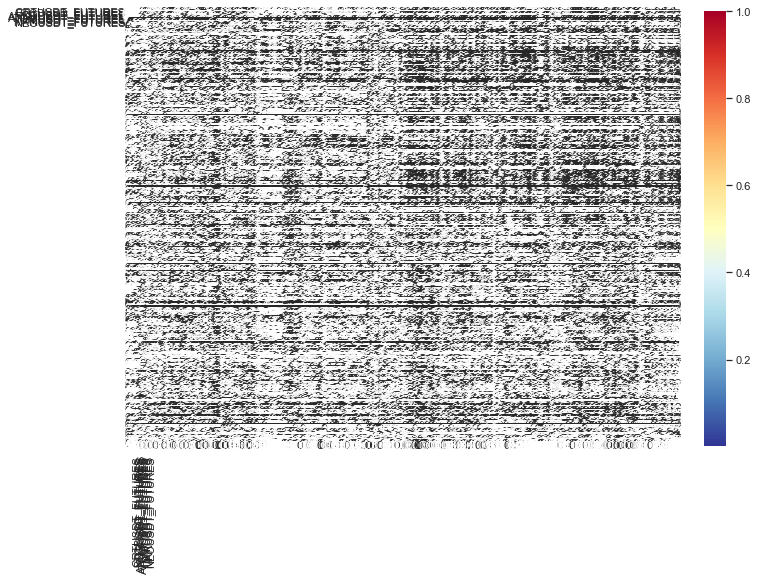

In [53]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
labels = df_closings.columns[11:20].values.flatten().tolist()
sns.heatmap(pvalue_matrix, cmap="RdYlBu_r", annot=True, robust=True, yticklabels=labels, xticklabels=labels)
plt.show()

<h2>Ranking the instruments by the 24h vol</h2>

In [16]:
tickers = await client.get_ticker()

In [20]:
df = pd.DataFrame(tickers)

In [24]:
df.volume = pd.to_numeric(df.volume)
df.quoteVolume = pd.to_numeric(df.quoteVolume)
df

,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,openPrice,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count
0,ETHBTC,-0.00400000,-6.916,0.05520751,0.05784000,0.05384100,1.69210000,0.05384100,17.71680000,0.05384200,...,0.05784100,0.05787400,0.05300600,4.066652e+05,2.245097e+04,1654885887436,1654972287436,345714404,346114238,399835
1,LTCBTC,-0.00010700,-5.462,0.00191099,0.00195900,0.00185200,45.47100000,0.00185100,82.17900000,0.00185200,...,0.00195900,0.00197200,0.00182800,3.228587e+05,6.169792e+02,1654885886205,1654972286205,80562806,80617098,54293
2,BNBBTC,-0.00028800,-2.947,0.00966587,0.00977400,0.00948600,0.05600000,0.00948600,8.00400000,0.00948700,...,0.00977400,0.00990300,0.00939000,9.770492e+04,9.444027e+02,1654885886075,1654972286075,187595174,187668723,73550
3,NEOBTC,-0.00000400,-1.034,0.00038917,0.00038700,0.00038300,0.40000000,0.00038300,539.67000000,0.00038400,...,0.00038700,0.00039900,0.00037100,6.627314e+04,2.579121e+01,1654885887362,1654972287362,43494988,43499725,4738
4,QTUMETH,0.00001800,0.823,0.00223151,0.00218500,0.00220600,52.80000000,0.00220300,29.50000000,0.00221000,...,0.00218800,0.00231700,0.00218000,1.469990e+04,3.280294e+01,1654885887383,1654972287383,5279230,5279859,630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,OPBUSD,-0.14300000,-15.801,0.84699131,0.90500000,0.76200000,185.99000000,0.76200000,13401.18000000,0.76400000,...,0.90500000,0.93500000,0.72700000,1.972861e+07,1.670996e+07,1654885885737,1654972285737,1207608,1261402,53795
2062,OPUSDT,-0.14400000,-15.877,0.84922848,0.90600000,0.76300000,800.18000000,0.76300000,33331.79000000,0.76500000,...,0.90700000,0.93500000,0.72800000,5.963953e+07,5.064759e+07,1654885887210,1654972287210,2250428,2335813,85386
2063,OGBUSD,-0.27700000,-7.599,3.74937495,3.64500000,3.36800000,1.10000000,3.36700000,118.50000000,3.37300000,...,3.64500000,4.10000000,3.30000000,2.873152e+05,1.077252e+06,1654885885430,1654972285430,136964,145051,8088
2064,KEYBUSD,-0.00035800,-8.658,0.00385243,0.00413500,0.00377700,176254.00000000,0.00377200,317362.00000000,0.00378300,...,0.00413500,0.00428700,0.00361400,1.449473e+10,5.583996e+07,1654885885363,1654972285363,108233,116733,8501


In [25]:
df.symbol.str.endswith("BTC")

0        True
1        True
2        True
3        True
4       False
        ...  
2061    False
2062    False
2063    False
2064    False
2065    False
Name: symbol, Length: 2066, dtype: bool

<h2>Filtering root-derivatives</h2>

In [ ]:
directories = ["Binance_Historical_1m_FUTURES_2_days_2022-06-07T21:34:10", "Binance_Historical_1m_SPOT_2_days_2022-06-07T21:35:14"]

In [40]:

spot = []
margin = []
with os.scandir('raw_data/%s' % directories[0]) as entries:
  for entry in entries:
    entry_arr = entry.name.split("_")
    # instrument = "_".join(entry_arr[0:2])
    margin.append(entry_arr[0])
        
with os.scandir('raw_data/%s' % directories[1]) as entries:
    for entry in entries:
      entry_arr = entry.name.split("_")
      # instrument = "_".join(entry_arr[0:2])
      spot.append(entry_arr[0])

intersection = set(spot).intersection(margin)
        